In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import sigpy as sp
import sigpy.plot as pl

import time
import sys
import numpy as np
import os
from os.path import abspath



import subtle.subtle_preprocess as sup
import subtle.subtle_plot as suplot
import subtle.subtle_io as suio

import SimpleITK as sitk


import matplotlib.pyplot as plt


/home/jon/anaconda/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
base_path = '/home/subtle/Data/Tiantan/NO21'
recon_path_sag = '/raid/jon/predictions/Tiantan_mpr_a12c1c/NO21_Sag/'
recon_path_ax = '/raid/jon/predictions/Tiantan_mpr_a12c1c/NO21_Ax/'
recon_path_cor = '/raid/jon/predictions/Tiantan_mpr_a12c1c/NO21_Cor/'

path_zero, path_low, path_high = suio.get_dicom_dirs(base_path, override=True)
print(path_zero, path_low, path_high)

/home/subtle/Data/Tiantan/NO21/3DT1WMPRAGE_SAG_CS4_301 /home/subtle/Data/Tiantan/NO21/3DT1WMPRAGE_SAG_CS4_601 /home/subtle/Data/Tiantan/NO21/3DT1WMPRAGE_SAG_CS4_701


In [3]:
im0, hd0 = suio.dicom_files(path_zero, normalize=False)
im1, hd1 = suio.dicom_files(path_low, normalize=False)
im2, hd2 = suio.dicom_files(path_high, normalize=False)
imr0, hdr0 = suio.dicom_files(recon_path_sag, normalize=False)
imr1, hdr1 = suio.dicom_files(recon_path_ax, normalize=False)
imr2, hdr2 = suio.dicom_files(recon_path_cor, normalize=False)
print(im0.shape, im1.shape, im2.shape, imr0.shape, imr1.shape, imr2.shape)

(196, 240, 240) (196, 240, 240) (196, 240, 240) (196, 240, 240) (196, 240, 240) (196, 240, 240)


<IPython.core.display.Javascript object>


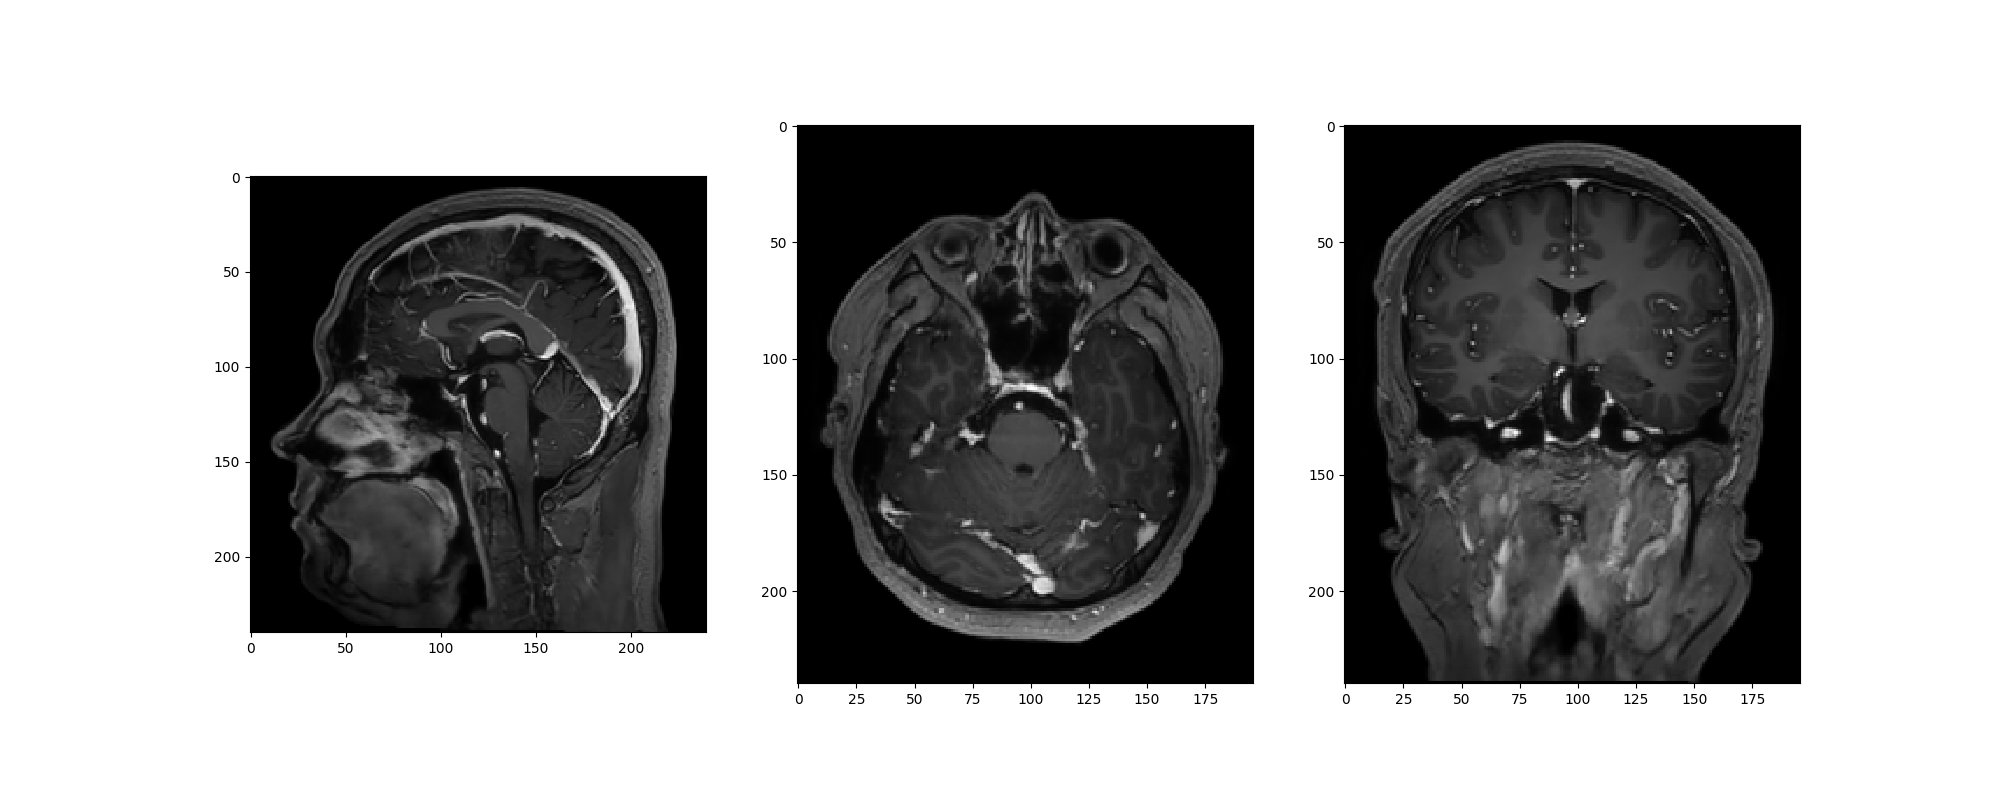

<IPython.core.display.Javascript object>


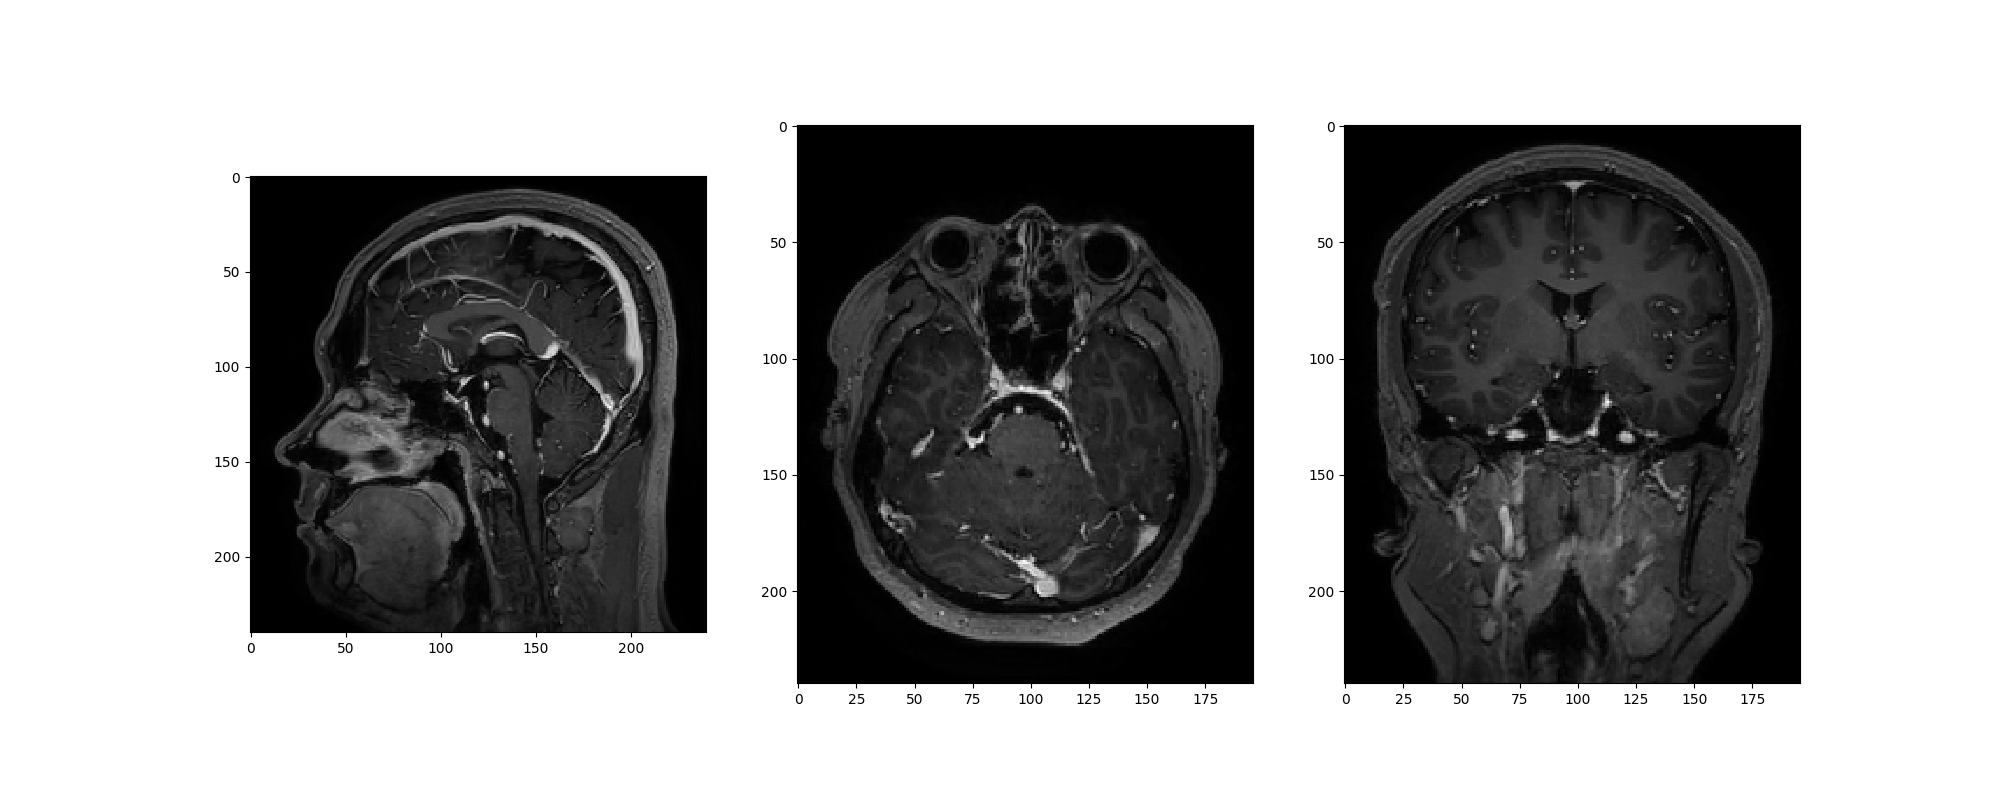

In [4]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(abs(imr0[imr0.shape[0]//2,...]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(abs(imr1[:,imr1.shape[1]//2,...]).T, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(abs(imr2[...,imr2.shape[2]//2]).T, cmap='gray')

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(abs(im2[im2.shape[0]//2,...]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(abs(im2[:,im2.shape[1]//2,...]).T, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(abs(im2[...,im2.shape[2]//2]).T, cmap='gray')

<IPython.core.display.Javascript object>


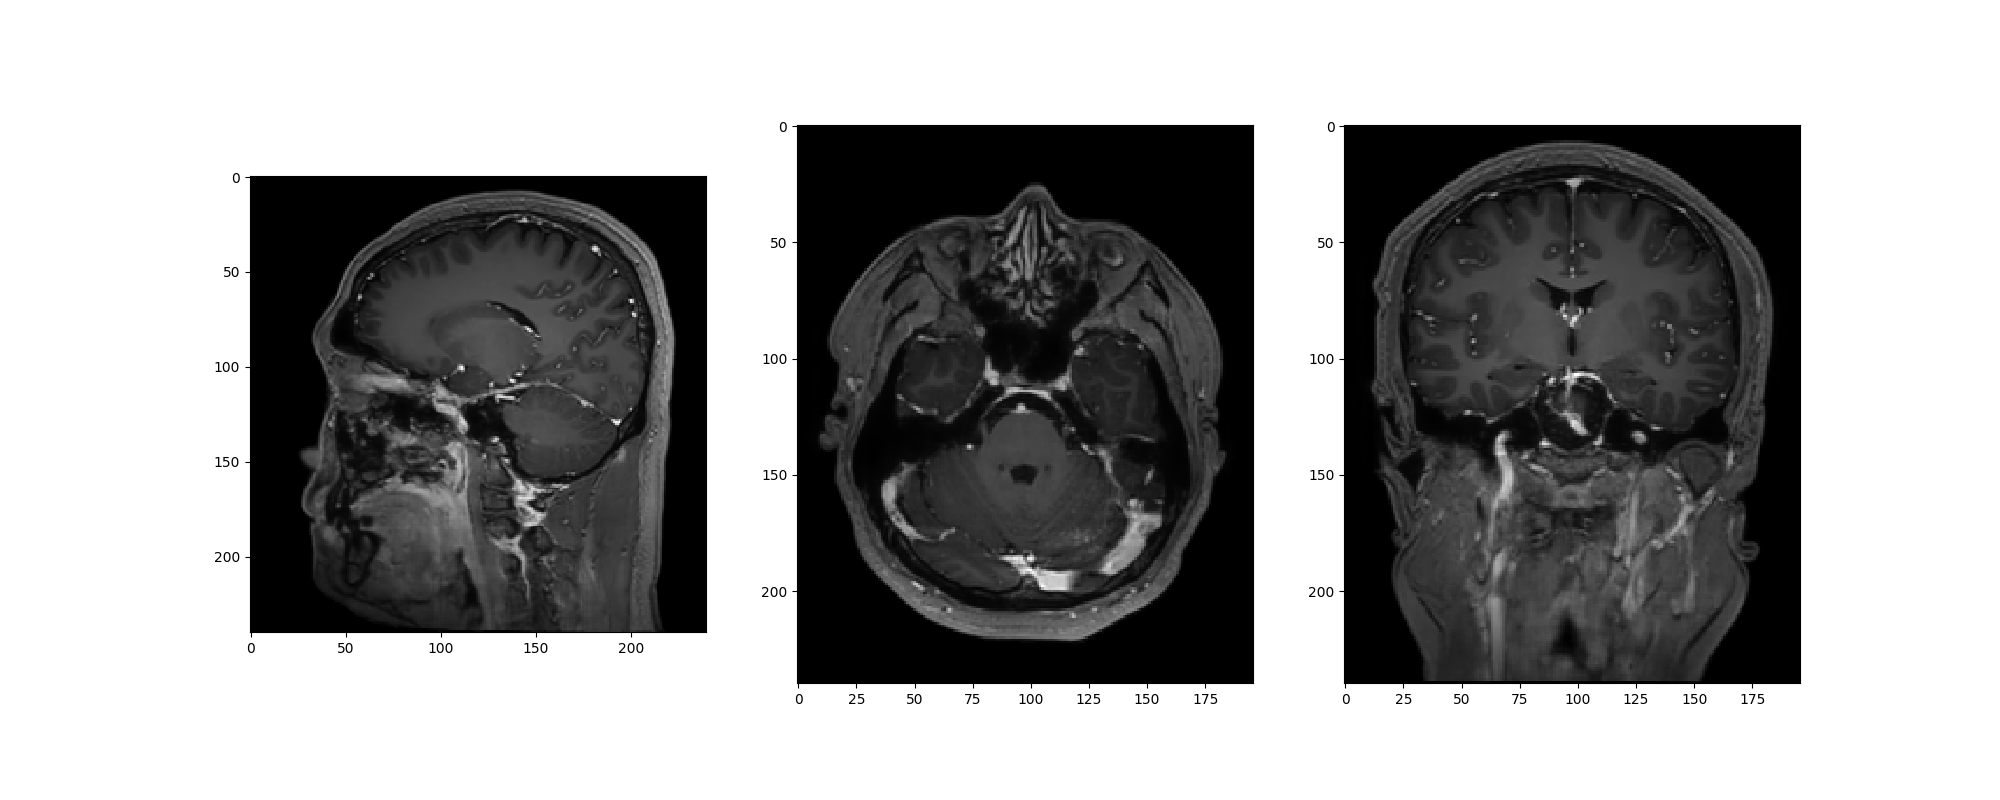

<IPython.core.display.Javascript object>


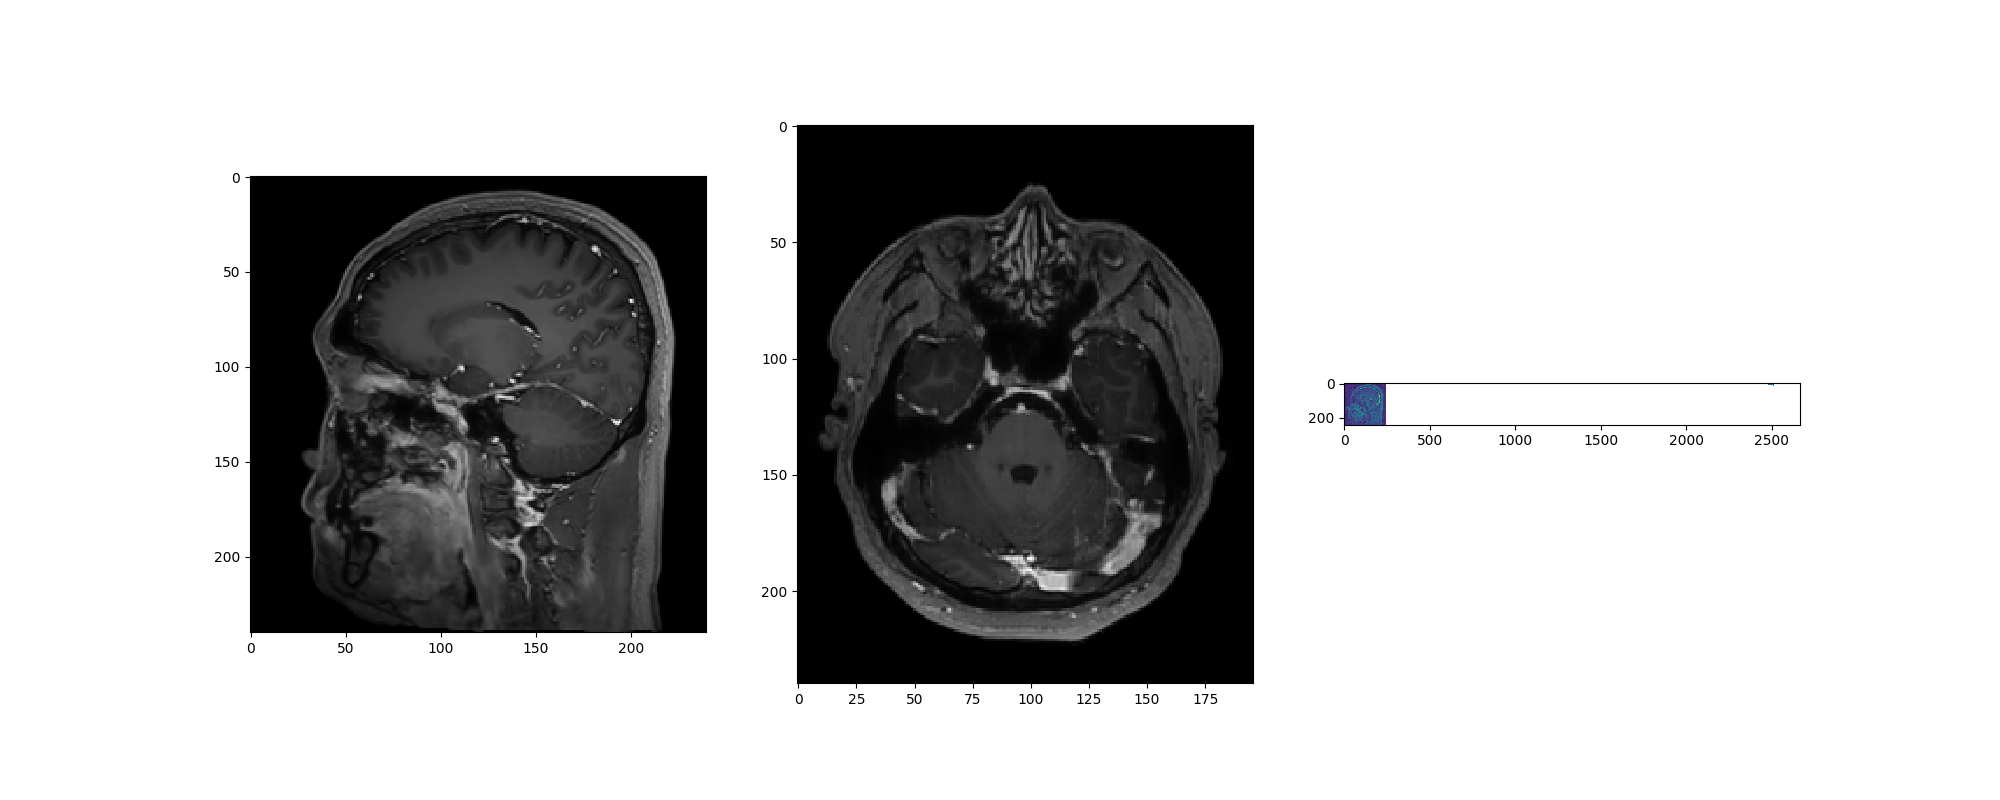

In [5]:
xx = (imr0 + imr1 + imr2) / 3.
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(abs(xx[82,...]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(abs(xx[:,124,...]).T, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(abs(xx[...,123]).T, cmap='gray')


plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(abs(imr0[82,...]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(abs(imr0[:,124,...]).T, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(abs(imr0[...,123]).T, cmap='gray')

In [6]:
x0 = im2.copy()
stdev = 50
x1 = x0 + np.random.randn(*x0.shape) * stdev
plt.imshow(x1[100,...])

In [7]:
import subtle.subtle_loss as suloss

idx = 100
sl0 = x0[idx,...]
sl1 = x1[idx,...]
print(x1.shape)
x01 = np.mean(np.power(x1 - x0, 2).reshape((x1.shape[0], -1)), axis=1)
plt.hist(x01, 30);

/home/jon/dev/SubtleGad/subtle/subtle_loss.py:32: UserWarning: import keras_contrib failed, replacing ssim loss with L1 loss
  warnings.warn('import keras_contrib failed, replacing ssim loss with L1 loss')


(196, 240, 240)


In [43]:
W = 63
S = 31
tic = time.time()
im0_blocks = sp.array_to_blocks(im0, [1, W, W], [1, S, S])
im1_blocks = sp.array_to_blocks(im1, [1, W, W], [1, S, S])
im2_blocks = sp.array_to_blocks(im2, [1, W, W], [1, S, S])
toc = time.time()
print('done', toc - tic)
print(im2_blocks.shape)

KeyboardInterrupt: 

In [ ]:
im_blocks = np.stack((im0_blocks, im1_blocks, im2_blocks))
print(im_blocks.shape)
pl.ImagePlot(im_blocks)

In [ ]:
def dimnorm(data, axis=None):
    if axis is None:
        return np.linalg.norm(data.ravel()) # faster
    else:
        return np.sqrt(np.sum(data**2, axis=axis))

In [ ]:
im_blocks_nrm = dimnorm(im_blocks, (-1, -2))
print(im_blocks_nrm.shape)

In [ ]:
pl.ImagePlot(im_blocks_nrm)

In [ ]:
import scipy.ndimage.interpolation


(196, 240, 240) (196, 240, 240) (196, 240, 240)
0.80295235


<IPython.core.display.Javascript object>


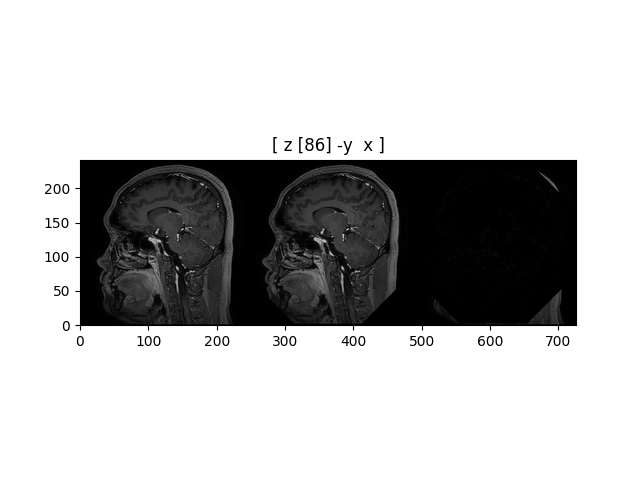

In [57]:
x = scipy.ndimage.interpolation.rotate(im2, 45, axes=(1, 2), reshape=False)
x2 = scipy.ndimage.interpolation.rotate(x, -45, axes=(1, 2), reshape=False)
print(im2.shape, x.shape, x2.shape)
print(dimnorm(x-x2)/dimnorm(x))
pl.ImagePlot(np.stack((im2, x2, im2-x2)))

<IPython.core.display.Javascript object>


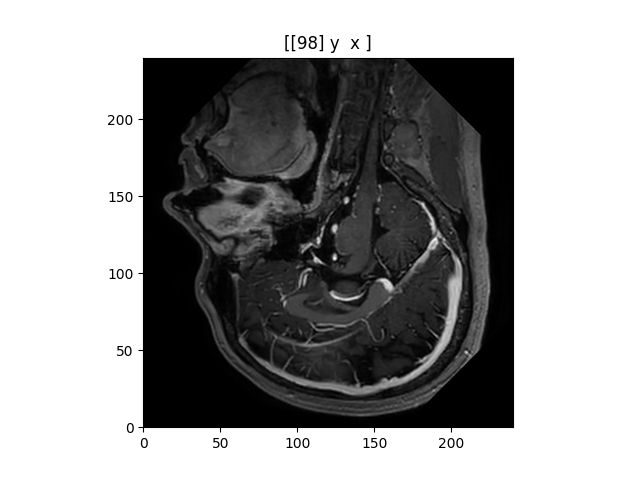

In [67]:
x_mask = x > 0
x2_mask = scipy.ndimage.interpolation.rotate(x * x_mask, -45, axes=(1, 2), reshape=False)
pl.ImagePlot(x2_mask)

(196, 240, 240) (196, 240, 240) (196, 240, 240)


<IPython.core.display.Javascript object>


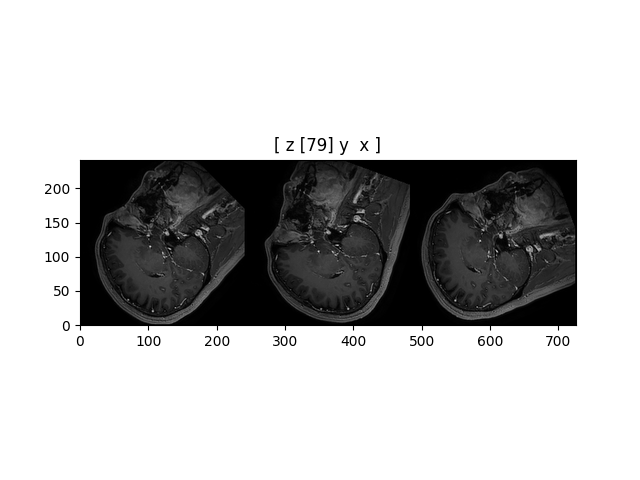

In [68]:
x1 = scipy.ndimage.interpolation.rotate(im2, 45, axes=(1, 2), reshape=False)
x2 = scipy.ndimage.interpolation.rotate(im2, 20, axes=(1, 2), reshape=False)
x3 = scipy.ndimage.interpolation.rotate(im2, 70, axes=(1, 2), reshape=False)

print(x1.shape, x2.shape, x3.shape)
pl.ImagePlot(np.stack((x1, x2, x3)))


In [81]:

x1r = scipy.ndimage.interpolation.rotate(x1, -45, axes=(1, 2), reshape=False)
x2r = scipy.ndimage.interpolation.rotate(x2, -20, axes=(1, 2), reshape=False)
x3r = scipy.ndimage.interpolation.rotate(x3, -70, axes=(1, 2), reshape=False)


In [86]:


m1r = np.array(x1r > 0, dtype=np.float)
m2r = np.array(x2r > 0, dtype=np.float)
m3r = np.array(x3r > 0, dtype=np.float)


<IPython.core.display.Javascript object>


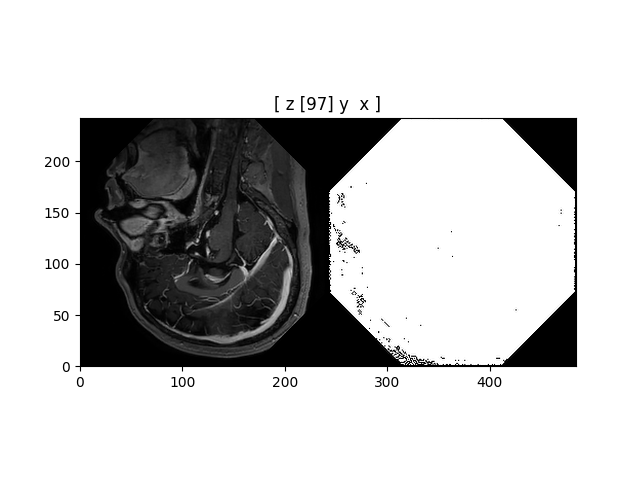

In [87]:
pl.ImagePlot(np.stack((x1r/np.max(x1r), m1r)))

<IPython.core.display.Javascript object>


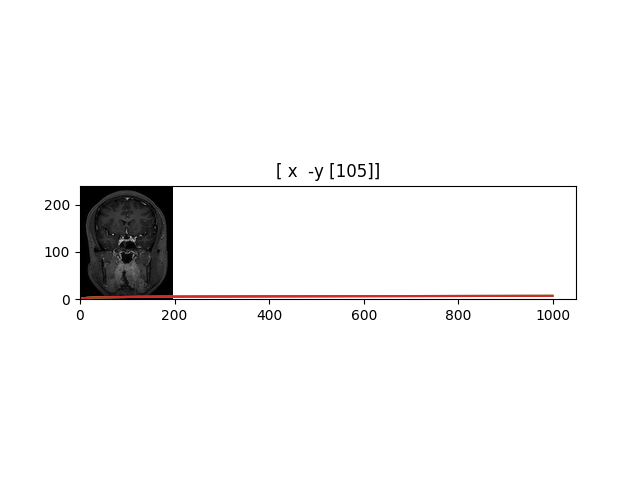

In [88]:
xr = np.divide(x1r+x2r+x3r, m1r+m2r+m3r, where=(m1r+m2r+m3r)>0)
pl.ImagePlot(xr)

In [93]:
x123 = np.stack((x1, x2, x3))



/home/jon/anaconda/envs/tensorflow/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jon/anaconda/envs/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [96]:
tic = time.time()
out = np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]), 0, x123)
toc = time.time()
print(toc - tic)

/home/jon/anaconda/envs/tensorflow/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jon/anaconda/envs/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


700.1745829582214


In [101]:
print(np.linspace(0, 90, 5, endpoint=False))

[ 0. 18. 36. 54. 72.]


In [113]:
z =  np.log(np.arange(5, 512))
print(z[-100:])


[6.02102335 6.02344759 6.02586597 6.02827852 6.03068526 6.03308622
 6.03548143 6.03787092 6.04025471 6.04263283 6.04500531 6.04737218
 6.04973346 6.05208917 6.05443935 6.05678401 6.0591232  6.06145692
 6.06378521 6.06610809 6.06842559 6.07073773 6.07304453 6.07534603
 6.07764224 6.0799332  6.08221891 6.08449941 6.08677473 6.08904488
 6.09130988 6.09356977 6.09582456 6.09807428 6.10031895 6.10255859
 6.10479323 6.10702289 6.10924758 6.11146734 6.11368218 6.11589213
 6.1180972  6.12029742 6.12249281 6.12468339 6.12686918 6.12905021
 6.13122649 6.13339804 6.13556489 6.13772705 6.13988455 6.14203741
 6.14418563 6.14632926 6.1484683  6.15060277 6.15273269 6.15485809
 6.15697899 6.15909539 6.16120732 6.1633148  6.16541785 6.16751649
 6.16961073 6.1717006  6.1737861  6.17586727 6.17794411 6.18001665
 6.18208491 6.18414889 6.18620862 6.18826412 6.19031541 6.19236249
 6.19440539 6.19644413 6.19847872 6.20050917 6.20253552 6.20455776
 6.20657593 6.20859003 6.21060008 6.2126061  6.2146081  6.2166

In [120]:
z = np.random.randn(100,100,100)
%timeit np.mean(z[0,:,:].copy())
%timeit np.mean(z[:,0,:].copy())
%timeit np.mean(z[:,:,0].copy())

25.6 µs ± 2.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
27.4 µs ± 99.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61 µs ± 2.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
